In [1]:
import tensorflow as tf
import os
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages are logged, 1 = INFO, 2 = WARNINGS, 3 = ERRORS
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Optionally disable oneDNN optimizations
# Additionally, suppress logging for certain elements if needed
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

gpus = tf.config.experimental.list_physical_devices('GPU')
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.7.0
Num GPUs Available:  1


# Step 1: Reading and Preprocessing the Data

In [2]:
import pandas as pd
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import Sequence
import glob
import random

In [3]:
# Assuming the CSV contains the combined data in the first column (e.g., folder;gesture;label)
train_df = pd.read_csv('/datasets/Project_data/train.csv')
val_df = pd.read_csv('/datasets/Project_data/val.csv')

# Split the first column into folder, gesture, and label columns
train_df[['folder', 'gesture', 'label']] = train_df.iloc[:, 0].str.split(';', expand=True)
val_df[['folder', 'gesture', 'label']] = val_df.iloc[:, 0].str.split(';', expand=True)

# Convert label column to integer
train_df['label'] = train_df['label'].astype(int)
val_df['label'] = val_df['label'].astype(int)

# Step 2: Image Data Generator


In [4]:
# Augmentation function
def augment_image(image):
    # Randomly flip the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Randomly rotate the image
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Randomly change brightness
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Random zoom
    image = tf.image.central_crop(image, central_fraction=tf.random.uniform(shape=[], minval=0.7, maxval=1.0))
    
    # Add random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2) 
    # Add random saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    return image

# Generator class to handle batches of video frames
class DataGenerator(Sequence):
    def __init__(self, df, batch_size, img_size, base_path, augment=False):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.base_path = base_path
        self.augment = augment  # Enable or disable augmentation

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_df)
        return X, y

    def __data_generation(self, batch_df):
        X = np.empty((self.batch_size, 30, *self.img_size, 3), dtype=np.float32)  # Pre-allocate for the batch
        y = np.empty((self.batch_size), dtype=np.int32)  # Pre-allocate for labels
    
        valid_count = 0  # To track how many valid samples we have
    
        for _, row in batch_df.iterrows():
            if valid_count >= self.batch_size:
                break
    
            folder_path = os.path.join(self.base_path, row['folder'])
            image_files = sorted(glob.glob(os.path.join(folder_path, '*.png')))
    
            if len(image_files) < 30:
                print(f"Not enough images in folder: {folder_path}, found {len(image_files)}")
                continue
    
            start_idx = random.randint(0, len(image_files) - 30)
            selected_images = image_files[start_idx:start_idx + 30]

            # Process each image in the selected sequence
            for j, img_path in enumerate(selected_images):
                img = cv2.imread(img_path)
            
                if img is None:
                    print(f"Failed to load image {img_path}")
                    continue
            
                # Resize the image using OpenCV (still as a NumPy array)
                img = cv2.resize(img, (self.img_size[0], self.img_size[1]))  # Resize to (100, 100)
            
                # Convert the image to a TensorFlow tensor and set the dtype to float32 for augmentation
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    img = tf.convert_to_tensor(img, dtype=tf.float32)
            
                # If augmentation is enabled, apply augmentation to the image tensor
                if self.augment:
                    img = augment_image(img)
            
                # Ensure the final size is (100, 100) after augmentation
                img = tf.image.resize(img, (self.img_size[0], self.img_size[1]))

                # Normalize the image to [0, 1] after augmentation and resizing
                img = img / 255.0
            
                # Store the resized, augmented, and normalized image in the batch
                X[valid_count, j,] = img.numpy()  # Convert tensor back to NumPy before storing

    
            y[valid_count] = row['label']
            valid_count += 1  # Increment count only after the full sample is processed
    
        # Return only the valid part of the batch
        return X[:valid_count], y[:valid_count]



# Step 3: Model Definition

In [5]:
# Model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout


def create_model(img_size=(100, 100, 3), num_classes=5, num_frames=30):
    model = Sequential()

    # 3D Convolutional Block 1
    model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=(num_frames, img_size[0], img_size[1], img_size[2])))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # 3D Convolutional Block 2
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Step 4: Train the Model

In [6]:
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback

# Parameters
batch_size = 32
img_size = (100, 100)  # Adjust image size
num_classes = train_df['label'].nunique()
data_train_dir = '/datasets/Project_data/train'
data_val_dir = '/datasets/Project_data/val'

In [7]:
# Create generators
train_gen = DataGenerator(train_df, batch_size=batch_size, img_size=img_size, base_path=data_train_dir)
val_gen = DataGenerator(val_df, batch_size=batch_size, img_size=img_size, base_path=data_val_dir)

# Create the model for 3D input (video sequences)
model = create_model(img_size=(img_size[0], img_size[1], 3), num_classes=num_classes, num_frames=30)

# Current Date and Time for Naming the Model
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)


# Custom Callback for Logging
class TrainingLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}:")
        print(f" - loss: {logs.get('loss')}")
        print(f" - accuracy: {logs.get('accuracy')}")
        print(f" - val_loss: {logs.get('val_loss')}")
        print(f" - val_accuracy: {logs.get('val_accuracy')}")


# Model Checkpoint filepath
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.keras'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',
                    save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    TrainingLogger()  # Add the logger to monitor the metrics
]

In [8]:
# Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks)
print(history.history.keys())
# For first model
first_model_history = history

# Log training details
print(f"Training completed. Model saved in {model_name}")

# Log training details
print(f"Training completed. Model saved in {model_name}")  # Parameters

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 8.0992 - accuracy: 0.1531
Epoch 00001: val_loss improved from inf to 1.60080, saving model to model_init_2024-10-0122_51_08.100293/model-00001-8.09916-0.15313-1.60080-0.21875.keras
Epoch 1:
 - loss: 8.09915828704834
 - accuracy: 0.15312500298023224
 - val_loss: 1.6008049249649048
 - val_accuracy: 0.21875
20/20 [==============================] - 71s 3s/step - loss: 8.0992 - accuracy: 0.1531 - val_loss: 1.6008 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 1.6161 - accuracy: 0.1797
Epoch 00002: val_loss improved from 1.60080 to 1.57012, saving model to model_init_2024-10-0122_51_08.100293/model-00002-1.61606-0.17969-1.57012-0.29167.keras
Epoch 2:
 - loss: 1.6160612106323242
 - accuracy: 0.1796875
 - val_loss: 1.5701169967651367
 - val_accuracy: 0.2916666567325592
20/20 [==============================] - 57s 3s/step - loss: 1.6161 - accuracy: 0.1797 - val_loss: 1.57

## Evaluate model functions

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np


def evaluate_model(history, model, val_gen):
    def plot_metrics(history):
        # Plot training & validation accuracy values
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.show()

    def compute_confusion_matrix_and_report(model, val_gen):
        y_true = []
        y_pred = []

        for i in range(len(val_gen)):
            X, y = val_gen[i]
            y_true.extend(y)
            y_pred_batch = model.predict(X)
            y_pred.extend(np.argmax(y_pred_batch, axis=1))

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)

        # Compute classification report
        report = classification_report(y_true, y_pred)
        print("Classification Report:\n", report)

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

    def print_epoch_results(history):
        # Check available keys in the history object
        print(history.history.keys())

        # Extract accuracy and loss values
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        # Print the results for each epoch
        print("Epoch\tTrain Loss\tVal Loss\tTrain Accuracy\tVal Accuracy")
        for i in range(len(train_loss)):
            print(f"{i + 1}\t{train_loss[i]:.4f}\t{val_loss[i]:.4f}\t{train_acc[i]:.4f}\t{val_acc[i]:.4f}")

        # Optionally, print the last epoch's results
        print("\nFinal Epoch Results:")
        print(f"Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")
        print(f"Train Accuracy: {train_acc[-1]:.4f}, Val Accuracy: {val_acc[-1]:.4f}")

    # Call the functions
    plot_metrics(history)
    compute_confusion_matrix_and_report(model, val_gen)
    print_epoch_results(history)

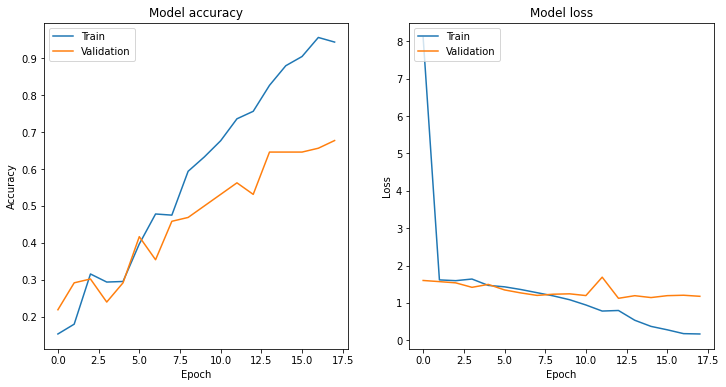

Confusion Matrix:
 [[10  2  2  2  1]
 [ 1 21  1  0  0]
 [ 3  4 10  5  0]
 [ 3  3  7  8  0]
 [ 3  1  2  5  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.59      0.54        17
           1       0.68      0.91      0.78        23
           2       0.45      0.45      0.45        22
           3       0.40      0.38      0.39        21
           4       0.67      0.15      0.25        13

    accuracy                           0.53        96
   macro avg       0.54      0.50      0.48        96
weighted avg       0.53      0.53      0.51        96



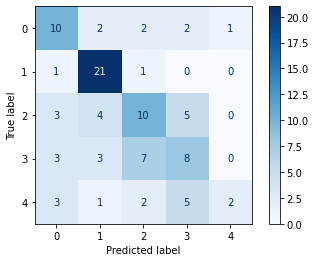

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
Epoch	Train Loss	Val Loss	Train Accuracy	Val Accuracy
1	8.0992	1.6008	0.1531	0.2188
2	1.6161	1.5701	0.1797	0.2917
3	1.5956	1.5371	0.3156	0.3021
4	1.6391	1.4176	0.2937	0.2396
5	1.4691	1.4954	0.2953	0.2917
6	1.4310	1.3479	0.3969	0.4167
7	1.3591	1.2679	0.4781	0.3542
8	1.2738	1.2017	0.4750	0.4583
9	1.1882	1.2334	0.5938	0.4688
10	1.0858	1.2436	0.6328	0.5000
11	0.9453	1.1970	0.6766	0.5312
12	0.7829	1.6889	0.7359	0.5625
13	0.7981	1.1238	0.7563	0.5312
14	0.5373	1.1938	0.8266	0.6458
15	0.3730	1.1438	0.8797	0.6458
16	0.2814	1.1947	0.9047	0.6458
17	0.1791	1.2059	0.9563	0.6562
18	0.1701	1.1775	0.9438	0.6771

Final Epoch Results:
Train Loss: 0.1701, Val Loss: 1.1775
Train Accuracy: 0.9438, Val Accuracy: 0.6771


In [10]:
evaluate_model(history, model, val_gen)

## Simple with Augmented

In [11]:
# Create generators
train_gen = DataGenerator(train_df, batch_size=batch_size, img_size=img_size, base_path=data_train_dir, augment=True)
val_gen = DataGenerator(val_df, batch_size=batch_size, img_size=img_size, base_path=data_val_dir, augment=True)

# Create the model for 3D input (video sequences)
model = create_model(img_size=(img_size[0], img_size[1], 3), num_classes=num_classes, num_frames=30)

# Current Date and Time for Naming the Model
curr_dt_time = datetime.datetime.now()
model_name = 'model_simple_augmented' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)


# Custom Callback for Logging
class TrainingLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}:")
        print(f" - loss: {logs.get('loss')}")
        print(f" - accuracy: {logs.get('accuracy')}")
        print(f" - val_loss: {logs.get('val_loss')}")
        print(f" - val_accuracy: {logs.get('val_accuracy')}")


# Model Checkpoint filepath
model_name = 'model_simple_augmented' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'
# Create directory if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model_simple_augmented-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.keras'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',
                    save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    TrainingLogger()  # Add the logger to monitor the metrics
]

In [12]:
# Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks)
print(history.history.keys())
# For simple augmented model
simple_augmented_model_history = history

# Log training details
print(f"Training completed. Model saved in {model_name}")

# Log training details
print(f"Training completed. Model saved in {model_name}")  # Parameters

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 4.7469 - accuracy: 0.1000
Epoch 00001: val_loss improved from inf to 1.60931, saving model to model_simple_augmented_2024-10-0123_09_04.543377/model_simple_augmented-00001-4.74692-0.10000-1.60931-0.23958.keras
Epoch 1:
 - loss: 4.7469162940979
 - accuracy: 0.10000000149011612
 - val_loss: 1.609311580657959
 - val_accuracy: 0.2395833283662796
20/20 [==============================] - 131s 7s/step - loss: 4.7469 - accuracy: 0.1000 - val_loss: 1.6093 - val_accuracy: 0.2396 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 1.6104 - accuracy: 0.2062
Epoch 00002: val_loss improved from 1.60931 to 1.60834, saving model to model_simple_augmented_2024-10-0123_09_04.543377/model_simple_augmented-00002-1.61038-0.20625-1.60834-0.23958.keras
Epoch 2:
 - loss: 1.6103769540786743
 - accuracy: 0.20624999701976776
 - val_loss: 1.6083383560180664
 - val_accuracy: 0.2395833283662796
20/20 [==================

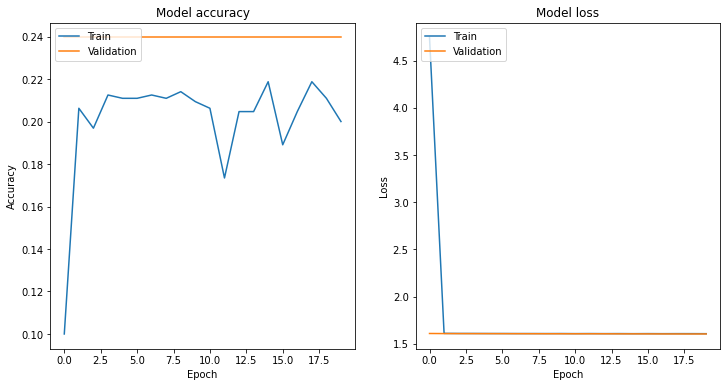

Confusion Matrix:
 [[ 0 17  0  0  0]
 [ 0 23  0  0  0]
 [ 0 22  0  0  0]
 [ 0 21  0  0  0]
 [ 0 13  0  0  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.24      1.00      0.39        23
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        13

    accuracy                           0.24        96
   macro avg       0.05      0.20      0.08        96
weighted avg       0.06      0.24      0.09        96



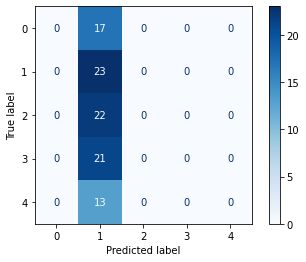

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
Epoch	Train Loss	Val Loss	Train Accuracy	Val Accuracy
1	4.7469	1.6093	0.1000	0.2396
2	1.6104	1.6083	0.2062	0.2396
3	1.6095	1.6081	0.1969	0.2396
4	1.6093	1.6079	0.2125	0.2396
5	1.6088	1.6078	0.2109	0.2396
6	1.6088	1.6074	0.2109	0.2396
7	1.6084	1.6072	0.2125	0.2396
8	1.6085	1.6069	0.2109	0.2396
9	1.6083	1.6066	0.2141	0.2396
10	1.6087	1.6064	0.2094	0.2396
11	1.6079	1.6062	0.2062	0.2396
12	1.6085	1.6063	0.1734	0.2396
13	1.6078	1.6061	0.2047	0.2396
14	1.6082	1.6055	0.2047	0.2396
15	1.6074	1.6055	0.2188	0.2396
16	1.6080	1.6051	0.1891	0.2396
17	1.6074	1.6047	0.2047	0.2396
18	1.6078	1.6045	0.2188	0.2396
19	1.6077	1.6041	0.2109	0.2396
20	1.6072	1.6045	0.2000	0.2396

Final Epoch Results:
Train Loss: 1.6072, Val Loss: 1.6045
Train Accuracy: 0.2000, Val Accuracy: 0.2396


In [13]:
evaluate_model(history, model, val_gen)

# Advanced Model

In [ ]:
from keras.layers import BatchNormalization

def create_advanced_model(img_size=(100, 100, 3), num_classes=5, num_frames=30):
    model = Sequential()

    # 3D Convolutional Block 1
    model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=(num_frames, img_size[0], img_size[1], img_size[2])))
    model.add(BatchNormalization())  # Normalize the activations of the previous layer
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # 3D Convolutional Block 2
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # 3D Convolutional Block 3
    model.add(Conv3D(128, (3, 3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatten the output from the convolutional layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))  # Dropout to prevent overfitting
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Create generators (with data augmentation for training)
train_gen = DataGenerator(train_df, batch_size=batch_size, img_size=img_size, base_path=data_train_dir, augment=True)
val_gen = DataGenerator(val_df, batch_size=batch_size, img_size=img_size, base_path=data_val_dir, augment=False)

# Instantiate the updated model
advanced_model = create_advanced_model(img_size=(img_size[0], img_size[1], 3), num_classes=num_classes, num_frames=30)

# Model Checkpoint filepath
model_name = 'model_advanced' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'
# Create directory if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model_advanced-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.keras'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',
                    save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    TrainingLogger()  # Add the logger to monitor the metrics
]

# Train the model
history = advanced_model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks)
advanced_model_history = history


Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 29.8532 - accuracy: 0.2328
Epoch 00001: val_loss improved from inf to 58.18620, saving model to model_advanced_2024-10-0123_09_04.543377/model_advanced-00001-29.85324-0.23281-58.18620-0.21875.keras
Epoch 1:
 - loss: 29.85323715209961
 - accuracy: 0.23281249403953552
 - val_loss: 58.18620300292969
 - val_accuracy: 0.21875
20/20 [==============================] - 120s 6s/step - loss: 29.8532 - accuracy: 0.2328 - val_loss: 58.1862 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 14.7076 - accuracy: 0.2359
Epoch 00002: val_loss improved from 58.18620 to 6.72839, saving model to model_advanced_2024-10-0123_09_04.543377/model_advanced-00002-14.70758-0.23594-6.72839-0.15625.keras
Epoch 2:
 - loss: 14.70758056640625
 - accuracy: 0.23593750596046448
 - val_loss: 6.7283935546875
 - val_accuracy: 0.15625
20/20 [==============================] - 118s 6s/step - loss: 14.7076 - 

In [ ]:
# For advanced model
advanced_model_history = history

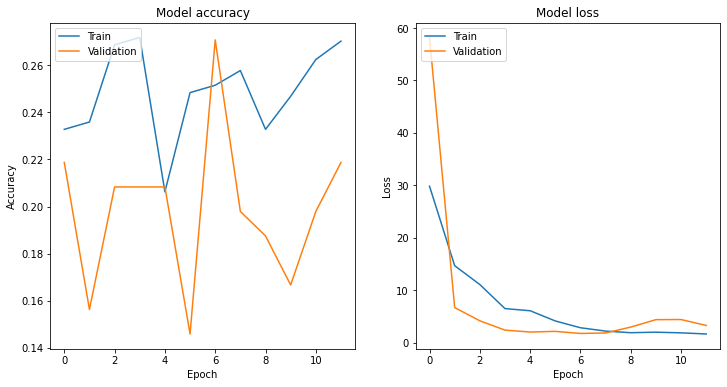

Confusion Matrix:
 [[ 0 17  0  0  0]
 [ 0 23  0  0  0]
 [ 0 22  0  0  0]
 [ 0 21  0  0  0]
 [ 0 13  0  0  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.24      1.00      0.39        23
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        13

    accuracy                           0.24        96
   macro avg       0.05      0.20      0.08        96
weighted avg       0.06      0.24      0.09        96



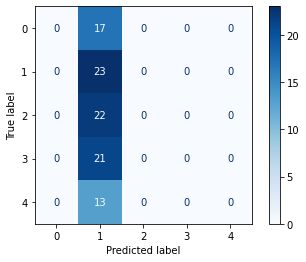

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
Epoch	Train Loss	Val Loss	Train Accuracy	Val Accuracy
1	29.8532	58.1862	0.2328	0.2188
2	14.7076	6.7284	0.2359	0.1562
3	11.1181	4.2129	0.2688	0.2083
4	6.5341	2.4352	0.2719	0.2083
5	6.1268	2.0703	0.2062	0.2083
6	4.1810	2.1985	0.2484	0.1458
7	2.8870	1.8019	0.2516	0.2708
8	2.2497	1.8923	0.2578	0.1979
9	1.9440	3.0145	0.2328	0.1875
10	2.0416	4.4303	0.2469	0.1667
11	1.9153	4.4535	0.2625	0.1979
12	1.7013	3.3229	0.2703	0.2188

Final Epoch Results:
Train Loss: 1.7013, Val Loss: 3.3229
Train Accuracy: 0.2703, Val Accuracy: 0.2188


In [ ]:
evaluate_model(history, model, val_gen)

## ConvLSTM-Based Model

In [ ]:
from tensorflow.keras.layers import ConvLSTM2D, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization


def create_convlstm_model(img_size=(100, 100, 3), num_classes=5, num_frames=30):
    model = Sequential()

    # ConvLSTM layer
    model.add(
        ConvLSTM2D(filters=64, kernel_size=(3, 3), input_shape=(num_frames, img_size[0], img_size[1], img_size[2]),
                   padding='same', return_sequences=True))
    model.add(BatchNormalization())

    # Another ConvLSTM layer (optional, can be added to increase depth)
    model.add(ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', return_sequences=True))
    model.add(BatchNormalization())

    # Final ConvLSTM layer with return_sequences=False
    model.add(ConvLSTM2D(filters=256, kernel_size=(3, 3), padding='same', return_sequences=False))
    model.add(BatchNormalization())

    # Flatten the extracted features and pass through fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Instantiate the ConvLSTM model
# convlstm_model = create_convlstm_model(img_size=(img_size[0], img_size[1], 3), num_classes=num_classes, num_frames=30)

# Model Checkpoint filepath
# model_name='model_convlstm'
# filepath_convlstm = model_name + '-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.keras'

# Callbacks
# callbacks_convlstm = [
#     EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     ModelCheckpoint(filepath_convlstm, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False,
#                     mode='auto', save_freq='epoch'),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
#     TrainingLogger()  # Add the logger to monitor the metrics
# ]

# Train the ConvLSTM model
# convlstm_history = convlstm_model.fit(train_gen, validation_data=val_gen, epochs=1, callbacks=callbacks_convlstm)

# Log training details
# print(f"Training completed. Model saved in {model_name}")


---------------------------------------------------------------------------
ResourceExhaustedError                    Traceback (most recent call last)
/tmp/ipykernel_465/1366719990.py in <module>
     31 
     32 # Instantiate the ConvLSTM model
---> 33 convlstm_model = create_convlstm_model(img_size=(img_size[0], img_size[1], 3), num_classes=num_classes, num_frames=30)
     34 
     35 # Model Checkpoint filepath

/tmp/ipykernel_465/1366719990.py in create_convlstm_model(img_size, num_classes, num_frames)
     21     # Flatten the extracted features and pass through fully connected layers
     22     model.add(Flatten())
---> 23     model.add(Dense(512, activation='relu'))
     24     model.add(Dropout(0.5))
     25     model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.8/dist-packages/tensorflow/python/training/tracking/base.py in _method_wrapper(self, *args, **kwargs)
    528     self._self_setattr_tracking = False  # pylint: disable=protected-access
    529     try:
--> 530       result = method(self, *args, **kwargs)
    531     finally:
    532       self._self_setattr_tracking = previous_value  # pylint: disable=protected-access

/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py in error_handler(*args, **kwargs)
     65     except Exception as e:  # pylint: disable=broad-except
     66       filtered_tb = _process_traceback_frames(e.__traceback__)
---> 67       raise e.with_traceback(filtered_tb) from None
     68     finally:
     69       del filtered_tb

/usr/local/lib/python3.8/dist-packages/keras/backend.py in random_uniform(self, shape, minval, maxval, dtype)
   1829       return self._generator.uniform(
   1830           shape=shape, minval=minval, maxval=maxval, dtype=dtype)
-> 1831     return tf.random.uniform(
   1832         shape=shape, minval=minval, maxval=maxval, dtype=dtype,
   1833         seed=self.make_legacy_seed())

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

## Modified ConvLSTM

In [ ]:
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, MaxPooling2D

# Define the ConvLSTM model
def create_convlstm_model(img_size=(100, 100, 3), num_classes=5, num_frames=30):
    model = Sequential()

    # ConvLSTM Block 1
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu', return_sequences=True,
                         input_shape=(num_frames, img_size[0], img_size[1], img_size[2])))
    model.add(BatchNormalization())

    # ConvLSTM Block 2
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    # ConvLSTM Block 3
    model.add(ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='relu', return_sequences=False))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Use MaxPooling2D here

    # Flatten the output from the ConvLSTM layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))  # Dropout to prevent overfitting
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Define DataGenerator with reduced batch size
train_gen = DataGenerator(train_df, batch_size=4, img_size=img_size, base_path=data_train_dir, augment=True)
val_gen = DataGenerator(val_df, batch_size=4, img_size=img_size, base_path=data_val_dir, augment=False)

# Instantiate the ConvLSTM model (no changes needed here)
model = create_convlstm_model(img_size=(img_size[0], img_size[1], 3), num_classes=num_classes, num_frames=30)

# Model Checkpoint filepath
model_name = 'model_convlstm' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'
# Create directory if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model_convlstm-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.keras'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',
                    save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    TrainingLogger()  # Add the logger to monitor the metrics
]

# Train the ConvLSTM model
history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks)
convlstm_model_history = history

Epoch 1/20
165/165 [==============================] - ETA: 0s - loss: 26.4689 - accuracy: 0.1909
Epoch 00001: val_loss improved from inf to 6.24628, saving model to model_convlstm_2024-10-0123_09_04.543377/model_convlstm-00001-26.46892-0.19091-6.24628-0.25000.keras
Epoch 1:
 - loss: 26.468915939331055
 - accuracy: 0.19090908765792847
 - val_loss: 6.24627685546875
 - val_accuracy: 0.25
165/165 [==============================] - 237s 1s/step - loss: 26.4689 - accuracy: 0.1909 - val_loss: 6.2463 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
165/165 [==============================] - ETA: 0s - loss: 5.2491 - accuracy: 0.2000
Epoch 00002: val_loss improved from 6.24628 to 1.63774, saving model to model_convlstm_2024-10-0123_09_04.543377/model_convlstm-00002-5.24911-0.20000-1.63774-0.17708.keras
Epoch 2:
 - loss: 5.249107837677002
 - accuracy: 0.20000000298023224
 - val_loss: 1.6377443075180054
 - val_accuracy: 0.1770833283662796
165/165 [==============================] - 230s 1s/step - los

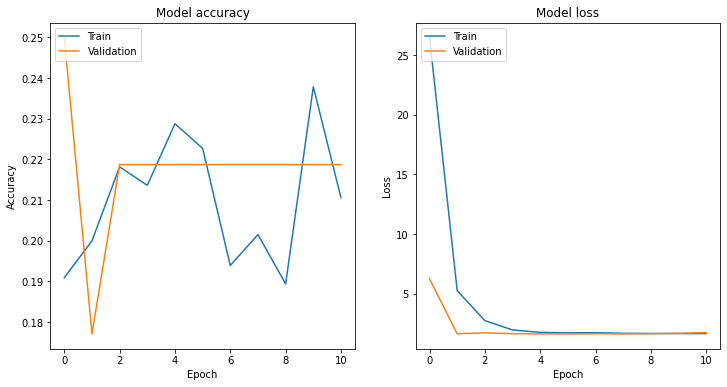

Confusion Matrix:
 [[ 0  0  0 17  0]
 [ 0  0  0 23  0]
 [ 0  0  0 22  0]
 [ 0  0  0 21  0]
 [ 0  0  0 13  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        22
           3       0.22      1.00      0.36        21
           4       0.00      0.00      0.00        13

    accuracy                           0.22        96
   macro avg       0.04      0.20      0.07        96
weighted avg       0.05      0.22      0.08        96



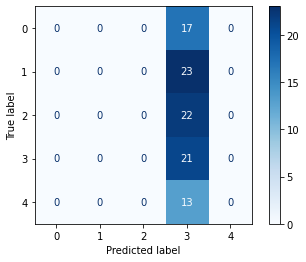

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
Epoch	Train Loss	Val Loss	Train Accuracy	Val Accuracy
1	26.4689	6.2463	0.1909	0.2500
2	5.2491	1.6377	0.2000	0.1771
3	2.7345	1.7077	0.2182	0.2188
4	1.9522	1.6393	0.2136	0.2188
5	1.7512	1.6211	0.2288	0.2188
6	1.7100	1.6150	0.2227	0.2188
7	1.7262	1.6311	0.1939	0.2188
8	1.6729	1.6213	0.2015	0.2188
9	1.6548	1.6327	0.1894	0.2188
10	1.6493	1.6745	0.2379	0.2188
11	1.6458	1.7297	0.2106	0.2188

Final Epoch Results:
Train Loss: 1.6458, Val Loss: 1.7297
Train Accuracy: 0.2106, Val Accuracy: 0.2188


In [ ]:
evaluate_model(history, model, val_gen)

## modified convlstm with lr and gradient clipping

In [ ]:
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, MaxPooling2D

# Define the ConvLSTM model
def create_convlstm_model(img_size=(100, 100, 3), num_classes=5, num_frames=30):
    model = Sequential()

    # ConvLSTM Block 1
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu', return_sequences=True,
                         input_shape=(num_frames, img_size[0], img_size[1], img_size[2])))
    model.add(BatchNormalization())

    # ConvLSTM Block 2
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    # ConvLSTM Block 3
    model.add(ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='relu', return_sequences=False))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Use MaxPooling2D here

    # Flatten the output from the ConvLSTM layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))  # Dropout to prevent overfitting
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
    
    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Define DataGenerator with reduced batch size
train_gen = DataGenerator(train_df, batch_size=4, img_size=img_size, base_path=data_train_dir, augment=True)
val_gen = DataGenerator(val_df, batch_size=4, img_size=img_size, base_path=data_val_dir, augment=False)

# Instantiate the ConvLSTM model (no changes needed here)
model = create_convlstm_model(img_size=(img_size[0], img_size[1], 3), num_classes=num_classes, num_frames=30)

# Model Checkpoint filepath
model_name = 'model_convlstm_lrclip' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'
# Create directory if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model_convlstm_lrclip-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.keras'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',
                    save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    TrainingLogger()  # Add the logger to monitor the metrics
]

# Train the ConvLSTM model
history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks)
convlstm_lrclip_model_history = history

Epoch 1/20
165/165 [==============================] - ETA: 0s - loss: 8.4473 - accuracy: 0.1939
Epoch 00001: val_loss improved from inf to 2.23084, saving model to model_convlstm_lrclip_2024-10-0123_09_04.543377/model_convlstm_lrclip-00001-8.44729-0.19394-2.23084-0.21875.keras
Epoch 1:
 - loss: 8.447287559509277
 - accuracy: 0.19393938779830933
 - val_loss: 2.2308402061462402
 - val_accuracy: 0.21875
165/165 [==============================] - 233s 1s/step - loss: 8.4473 - accuracy: 0.1939 - val_loss: 2.2308 - val_accuracy: 0.2188 - lr: 1.0000e-04
Epoch 2/20
165/165 [==============================] - ETA: 0s - loss: 3.3029 - accuracy: 0.1788
Epoch 00002: val_loss did not improve from 2.23084
Epoch 2:
 - loss: 3.3029356002807617
 - accuracy: 0.17878787219524384
 - val_loss: 4.325772762298584
 - val_accuracy: 0.2395833283662796
165/165 [==============================] - 225s 1s/step - loss: 3.3029 - accuracy: 0.1788 - val_loss: 4.3258 - val_accuracy: 0.2396 - lr: 1.0000e-04
Epoch 3/20
165

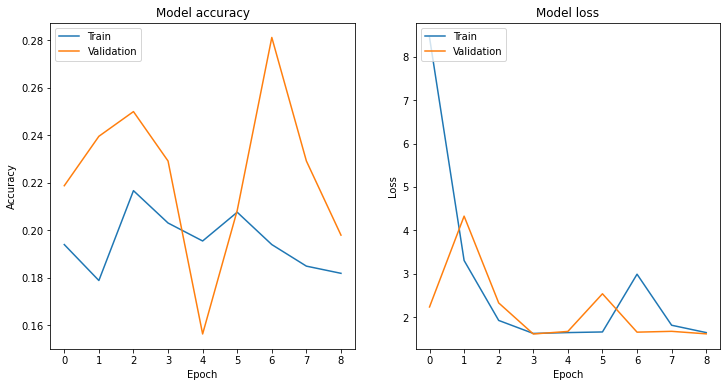

Confusion Matrix:
 [[ 0  2 15  0  0]
 [ 0  0 21  0  2]
 [ 0  0 22  0  0]
 [ 0  0 21  0  0]
 [ 0  0 13  0  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        23
           2       0.24      1.00      0.39        22
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        13

    accuracy                           0.23        96
   macro avg       0.05      0.20      0.08        96
weighted avg       0.05      0.23      0.09        96



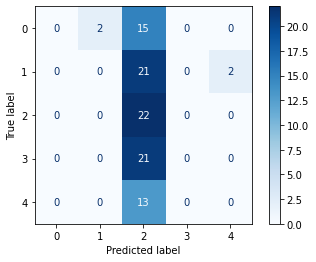

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
Epoch	Train Loss	Val Loss	Train Accuracy	Val Accuracy
1	8.4473	2.2308	0.1939	0.2188
2	3.3029	4.3258	0.1788	0.2396
3	1.9203	2.3240	0.2167	0.2500
4	1.6202	1.6079	0.2030	0.2292
5	1.6399	1.6664	0.1955	0.1562
6	1.6543	2.5350	0.2076	0.2083
7	2.9865	1.6499	0.1939	0.2812
8	1.8094	1.6688	0.1848	0.2292
9	1.6399	1.6109	0.1818	0.1979

Final Epoch Results:
Train Loss: 1.6399, Val Loss: 1.6109
Train Accuracy: 0.1818, Val Accuracy: 0.1979


In [ ]:
evaluate_model(history, model, val_gen)

## Plot comparison and select best model

Model                Train Loss      Val Loss        Train Accuracy       Val Accuracy        
----------------------------------------------------------------------------------------------
First Model          0.1701          1.1775          0.9438               0.6771              
Simple Augmented Model 1.6072          1.6045          0.2000               0.2396              
Advanced Model       1.7013          3.3229          0.2703               0.2188              
ConvLSTM Model       1.6458          1.7297          0.2106               0.2188              
ConvLSTM LR Clip Model 1.6399          1.6109          0.1818               0.1979              

### Interpretation ###
The model with the highest training accuracy is First Model (0.9438).
The model with the best generalization (highest validation accuracy) is First Model (0.6771).
The model with the lowest validation loss is First Model (1.1775), indicating the least overfitting.


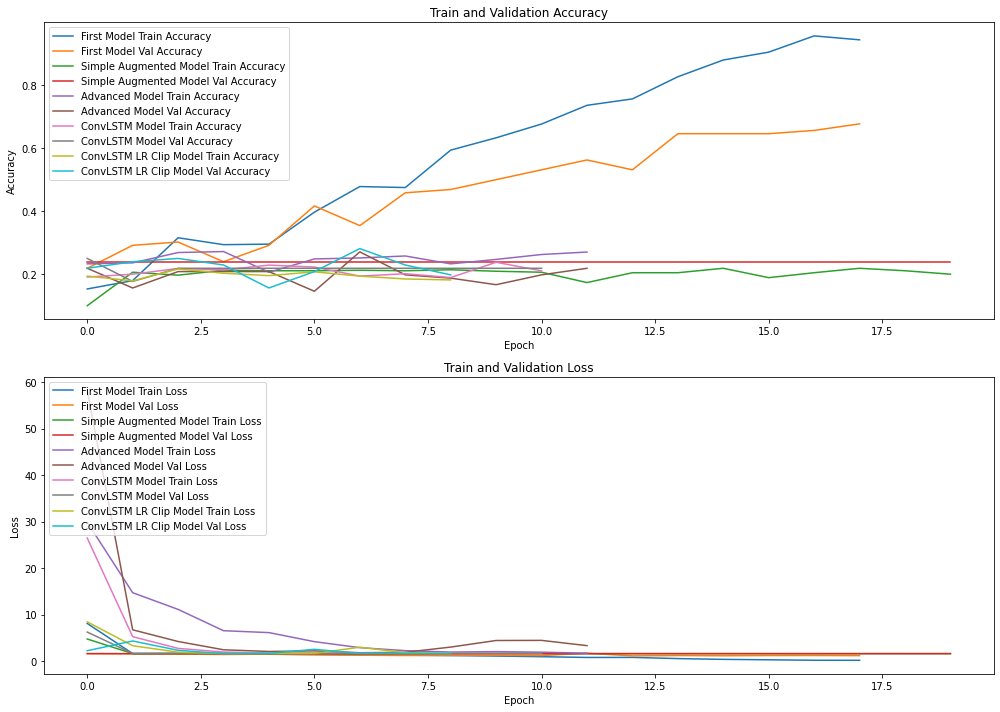

In [ ]:
import matplotlib.pyplot as plt


# Print Final Values in a Comparison Table for Five Models
def print_comparison_table_extended(five_model_histories):
    header = f"{'Model':<20} {'Train Loss':<15} {'Val Loss':<15} {'Train Accuracy':<20} {'Val Accuracy':<20}"
    separator = '-' * len(header)

    # Print the table header
    print(header)
    print(separator)

    # Print each model's final metrics
    for model_name, history in five_model_histories.items():
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]

        print(f"{model_name:<20} {train_loss:<15.4f} {val_loss:<15.4f} {train_acc:<20.4f} {val_acc:<20.4f}")


# Interpretation Based on Results for Five Models
def interpret_results_extended(five_model_histories):
    final_train_accs = {}
    final_val_accs = {}
    final_val_losses = {}

    for model_name, history in five_model_histories.items():
        final_train_accs[model_name] = history.history['accuracy'][-1]
        final_val_accs[model_name] = history.history['val_accuracy'][-1]
        final_val_losses[model_name] = history.history['val_loss'][-1]

    print("\n### Interpretation ###")

    # Identify model with highest training accuracy
    best_train_acc_model = max(final_train_accs, key=final_train_accs.get)
    print(
        f"The model with the highest training accuracy is {best_train_acc_model} ({final_train_accs[best_train_acc_model]:.4f}).")

    # Identify model with highest validation accuracy
    best_val_acc_model = max(final_val_accs, key=final_val_accs.get)
    print(
        f"The model with the best generalization (highest validation accuracy) is {best_val_acc_model} ({final_val_accs[best_val_acc_model]:.4f}).")

    # Identify model with lowest validation loss
    best_val_loss_model = min(final_val_losses, key=final_val_losses.get)
    print(
        f"The model with the lowest validation loss is {best_val_loss_model} ({final_val_losses[best_val_loss_model]:.4f}), indicating the least overfitting.")


# Plot combined metrics for five models
def plot_combined_metrics(five_model_histories):
    plt.figure(figsize=(14, 10))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    for model_name, history in five_model_histories.items():
        plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{model_name} Val Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    for model_name, history in five_model_histories.items():
        plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{model_name} Val Loss')
    plt.title('Train and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


# Example usage
five_model_histories = {
    "First Model": first_model_history,
    "Simple Augmented Model": simple_augmented_model_history,
    "Advanced Model": advanced_model_history,
    "ConvLSTM Model": convlstm_model_history,
    "ConvLSTM LR Clip Model": convlstm_lrclip_model_history
}

print_comparison_table_extended(five_model_histories)
interpret_results_extended(five_model_histories)
plot_combined_metrics(five_model_histories)

